In [1]:
import pandas as pd
import numpy as np
import os
import sys

current_working_dir = os.getcwd()
print(f"Current Working Directory: {current_working_dir}")
project_root = os.path.dirname(current_working_dir)
modules_path = os.path.join(project_root, 'Modules')
if modules_path not in sys.path:
    sys.path.append(modules_path)
    print(f"Added to sys.path for custom modules: {modules_path}")
data_folder_path = os.path.join(project_root, 'Data')
data_file_name = "OPCL_20000103_20201231.csv"   # Is this log(returns) or just returns
data_file_path = os.path.join(data_folder_path, data_file_name)

Current Working Directory: c:\Users\james\ICAIF_25\Current_Code\Script
Added to sys.path for custom modules: c:\Users\james\ICAIF_25\Current_Code\Modules


In [2]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from parallelized_runs import run_sliding_window_var_evaluation_vectorized
import multiprocessing
import subprocess

warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

try:
    from signet.cluster import Cluster
except ImportError:
    print("Signet package not found. Attempting to install from GitHub...")
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "git+https://github.com/alan-turing-institute/SigNet.git"]
        )
        # This part of the code should go first since importing parallelized_runs already requires the signet package
        from signet.cluster import Cluster
        print("Signet package installed successfully.")
    except Exception as e:
        print(f"Error installing Signet package: {e}")
        print("Please install it manually: pip install git+https://github.com/alan-turing-institute/SigNet.git")

# !pip install padasip
subprocess.check_call([sys.executable, "-m", "pip", "install", "sktime"])

ModuleNotFoundError: No module named 'parallelized_runs'

## Run on Train Dataset

In [3]:
multiprocessing.freeze_support()

df = pd.read_csv(data_file_path) # Assumes file exists and is readable

df.set_index('ticker', inplace=True)
df.columns = pd.to_datetime(df.columns.str.lstrip('X'), format='%Y%m%d').strftime('%Y-%m-%d')
df_cleaned = df.dropna().transpose() # Assumes dropna results in non-empty df
df_cleaned.index = pd.to_datetime(df_cleaned.index)
print("Data loaded and cleaned. Sample (first 5 rows/cols):")
print(df_cleaned.iloc[0:5,0:5])
print(f"Shape of the cleaned data: {df_cleaned.shape}")

# train_data_ratio = 20/21
train_data_ratio = 8/21
split_index = int(train_data_ratio * len(df_cleaned))
df_train_dataset = df_cleaned.iloc[:split_index]
df_test_dataset = df_cleaned.iloc[split_index:]

##################################################################### PARAMETERS #####################################################################
# I think we also need a train-test split here
initial_lookback_len = 252
# initial_lookback_len = 100
evaluation_len = 20 # I feel like this could be 252? Refer to our discussion
# num_clusters_config = [5] # Why 50, 100, 150?
# num_clusters_config = [3,5,8,10,11,12,15,20]
num_clusters_config = [3,5,8,11]
num_clusters_config = [3]
# num_clusters_config = [4,6,12,15]
cluster_method_config = 'SPONGE_sym'
sigma_config = 0.01 # This is a hyperparameter for SPONGE, ... hyperparameter tuning? Usual: 0.01 (less sparse), 0.1 (more sparse)
# num_windows_config = 238 # Ensure df_cleaned has enough data for this
num_windows_config = 83 # 8 years of data
repetitions = 1 # This should not be \"multiplied\" for the number of runs, if cluster initialization is to be refreshed every window.
# var_orders_config = [1,2,3,4,5,10,20] # Ensure initial_lookback_len - evaluation_len > max(var_orders_config)
var_orders_config = [1,2,3,4,5]
var_orders_config = [1,2]
# var_orders_config = [5] # Ensure initial_lookback_len - evaluation_len > max(var_orders_config)
max_threads = 12 # Must be tuned to your PC's CPU/RAM limitations
pnl_method = "naive"
####################################################################################################################################################
# Basic check for parameter sanity (example)
if not (initial_lookback_len - evaluation_len > max(var_orders_config)):
    raise ValueError("Insufficient lookback length for hyperparameter evaluation based on var_orders_config and evaluation_len.")
if not (df_cleaned.shape[0] >= (num_windows_config) * evaluation_len + initial_lookback_len):
    raise ValueError("Insufficient total data for the specified number of windows, lookback, and evaluation lengths.")


all_lags_combined_pnl = []
sample_forecast_details = {}



Data loaded and cleaned. Sample (first 5 rows/cols):
ticker            AA       ABM       ABT       ADI       ADM
2000-01-03 -0.013042 -0.009188 -0.007117 -0.036071  0.000000
2000-01-04  0.010043  0.012346 -0.012786 -0.044261  0.005277
2000-01-05  0.047628 -0.006192  0.011111  0.014493 -0.015915
2000-01-06 -0.011713  0.000000  0.032553 -0.027719  0.010695
2000-01-07 -0.016118  0.003091  0.028573  0.033654  0.005249
Shape of the cleaned data: (5279, 663)


In [4]:
# print(f"\n===== Running Parallelized Grid Search Evaluation (Simplified Edges) =====")
# results_dict = run_sliding_window_var_evaluation_vectorized(
#     asset_returns_df=df_train_dataset,
#     initial_lookback_len=initial_lookback_len,
#     eval_len=evaluation_len,
#     repetitions=repetitions,
#     n_clusters_config=num_clusters_config,
#     cluster_method=cluster_method_config,
#     var_order_config=var_orders_config,
#     sigma_intra_cluster=sigma_config,
#     num_windows_config=num_windows_config,
#     store_sample_forecasts=True,
#     run_naive_var_comparison=True,
#     max_threads=max_threads,
#     pnl_method=pnl_method
# )

# all_lags_combined_pnl.extend(results_dict['cluster_avg_pnl_list'])
# if 'naive_avg_pnl_list' in results_dict: # Still check as it's optional
#     all_lags_combined_pnl.extend(results_dict['naive_avg_pnl_list'])

# sample_forecast_details['forecast'] = results_dict.get('sample_forecast_cluster')
# sample_forecast_details['actual'] = results_dict.get('sample_actual_cluster')
# sample_forecast_details['window_idx'] = results_dict.get('sample_window_idx_cluster')
# sample_forecast_details['method'] = 'Clustered VAR (Parallel Grid Search, Simplified)'

# df_all_pnl_by_lag_method = pd.DataFrame(all_lags_combined_pnl) # Assumes all_lags_combined_pnl is not empty

# print("\n--- Grid Search Completed (Parallelized, Simplified) ---")
# print("\nAverage Window PNL per Selected Lag Order and Method:")
# pivot_index_cols = ['VAR_Order']
# if 'N_Clusters' in df_all_pnl_by_lag_method.columns and \
#     any(item['Method'] == 'Clustered VAR' for item in all_lags_combined_pnl if 'Method' in item):
#     pivot_index_cols.append('N_Clusters')

# avg_pnl_pivot = df_all_pnl_by_lag_method.pivot_table(
#     index=pivot_index_cols,
#     columns='Method',
#     values='Avg_Window_PNL',
#     aggfunc='mean'
# )
# print(avg_pnl_pivot)

# # Plotting (assumes data is present for plots)
# plt.figure(figsize=(14, 8))
# sns.boxplot(x='VAR_Order', y='Avg_Window_PNL', hue='Method', data=df_all_pnl_by_lag_method)
# plt.title(f'Distribution of Average Window PNL by Selected VAR Lag Order and Method')
# plt.xlabel('Selected VAR Lag Order for Window')
# plt.ylabel(f'Average Window PNL')
# plt.legend(title='Forecast Method')
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# sample_forecast = sample_forecast_details['forecast']
# sample_actual = sample_forecast_details['actual']
# stored_window_idx = sample_forecast_details.get('window_idx') # Removed "N/A" default
# method_name = sample_forecast_details.get('method')

# title_var_order, title_n_clusters = "N/A", "N/A" # Keep N/A for title if not found
# # Simplified logic for getting title parameters
# sample_window_data_rows = df_all_pnl_by_lag_method[
#     (df_all_pnl_by_lag_method['Window_ID'] == stored_window_idx) &
#     (df_all_pnl_by_lag_method['Method'] == 'Clustered VAR')
# ]
# if not sample_window_data_rows.empty: # Still need this check for robustness of title
#     row = sample_window_data_rows.iloc[0]
#     title_var_order = row['VAR_Order']
#     if 'N_Clusters' in row.index:
#         title_n_clusters = row['N_Clusters']

# print(f"\n--- Plotting Predictions vs. Actuals for Sample Window {stored_window_idx + 1 if isinstance(stored_window_idx, int) else stored_window_idx} ({method_name}) ---")
# print(f"Params for this sample: VAR Lag={title_var_order}, N_Clusters={title_n_clusters}")

# # Assumes sample_forecast and sample_actual are valid DataFrames with columns
# # num_items_to_plot = min(3, sample_forecast.shape[1], sample_actual.shape[1])
# # for i in range(num_items_to_plot):
# #     item_name = sample_forecast.columns[i]
# #     # Assumes item_name is in sample_actual.columns
# #     plt.figure(figsize=(14, 7))
# #     actual_plot_data = sample_actual[item_name].values[title_var_order-1:]
# #     forecast_plot_data = sample_forecast[item_name].values
# #     min_plot_len = min(len(actual_plot_data), len(forecast_plot_data))

# #     sns.lineplot(data=actual_plot_data[:min_plot_len], label=f'Actual - {item_name}', marker='o', linestyle='-')
# #     sns.lineplot(data=forecast_plot_data[:min_plot_len], label=f'Forecast - {item_name}', marker='x', linestyle='--')
# #     plt.title(f'Prediction vs. Actual for {item_name} (Window {stored_window_idx + 1 if isinstance(stored_window_idx, int) else stored_window_idx}, VAR Lag {title_var_order}, N_Clust {title_n_clusters})')
# #     plt.xlabel('Forecast Step')
# #     plt.ylabel('Return Value (Cluster)')
# #     plt.legend()
# #     plt.grid(True)
# #     plt.tight_layout()
# #     plt.show()

## Plot Training PnL

In [5]:
# from plot_results import *

# strategy_names = {
#     'naive': 'Naive',
#     'weighted': 'Weight by Predicted Return',
#     'top': 'Take Top Predictions (by Forecasted Returns)'
# }

# plot_returns(results_dict, convert_to_linear=False, strategy=strategy_names[pnl_method])
# plot_interwindow_errors(results_dict)
# plot_inwindow_errors(results_dict)

In [6]:
from plot_results import *
def run_for_strategy_type(pnl_method):
    results_dict = run_sliding_window_var_evaluation_vectorized(
        asset_returns_df=df_train_dataset,
        initial_lookback_len=initial_lookback_len,
        eval_len=evaluation_len,
        repetitions=repetitions,
        n_clusters_config=num_clusters_config,
        cluster_method=cluster_method_config,
        var_order_config=var_orders_config,
        sigma_intra_cluster=sigma_config,
        num_windows_config=num_windows_config,
        store_sample_forecasts=True,
        run_naive_var_comparison=True,
        max_threads=max_threads,
        pnl_method=pnl_method
    )

    strategy_names = {
        'naive': 'Naive',
        'weighted': 'Weight by Predicted Return',
        'top': 'Take Top Predictions (by Forecasted Returns)'
    }

    print(results_dict['cluster_avg_pnl_list'])

    plot_returns(results_dict, strategy=strategy_names[pnl_method])
    # plot_interwindow_errors(results_dict)
    # plot_inwindow_errors(results_dict)

In [7]:
# print(results_dict.keys())

# print(len(results_dict['cluster_avg_pnl_list']))
# print(results_dict['cluster_avg_pnl_list'][0])
# print(results_dict['sample_forecast_cluster'])
# print(results_dict['sample_actual_cluster'])

# import pickle
# with open("Saved_Runs/long_run_results_dict.pkl", "wb", encoding="utf8") as file:
#     pickle.dump(results_dict, file)

# import pickle
# with open("Saved_Runs/long_run_results_dict.pkl", "r", encoding="utf8") as file:
#     results_dict = pickle.load(file)

In [8]:
from plot_results import *
pnl_list = run_sliding_window_var_evaluation_vectorized(
    asset_returns_df=df_train_dataset,
    initial_lookback_len=initial_lookback_len,
    eval_len=evaluation_len,
    repetitions=repetitions,
    n_clusters_config=num_clusters_config,
    cluster_method=cluster_method_config,
    var_order_config=var_orders_config,
    sigma_intra_cluster=sigma_config,
    num_windows_config=num_windows_config,
    store_sample_forecasts=True,
    run_naive_var_comparison=True,
    max_threads=max_threads,
    pnl_method=pnl_method
)

# strategy_names = {
#     'naive': 'Naive',
#     'weighted': 'Weight by Predicted Return',
#     'top': 'Take Top Predictions (by Forecasted Returns)'
# }

# print(results_dict['cluster_avg_pnl_list'])

# plot_returns(results_dict, strategy=strategy_names[pnl_method])

Phase 1: Preparing hyperparameter evaluation tasks...
Phase 1: Running 166 hyperparameter PNL calculations in parallel...
Phase 1: Hyperparameter PNL calculations completed.
Phase 2: Determining best hyperparameters and preparing final evaluation tasks...
Phase 2: Running 83 final window evaluations in parallel...
Phase 2: Final window evaluations completed.


In [11]:
from parallelized_runs import calculate_pnl

forecast_df = pd.DataFrame(np.array([[.1,.1,.1],
                              [.1,.2,.2],
                              [.3,.3,.3]]))

actual_df = pd.DataFrame(np.array([[.2,-.1,.5],
                              [.6,.23,.2],
                              [.4,.3,.3]]))

print(calculate_pnl(forecast_df, actual_df, pnl_strategy="weighted"))

0    1.258320
1    1.356425
2    1.397181
dtype: float64


In [9]:
print(pnl_list)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


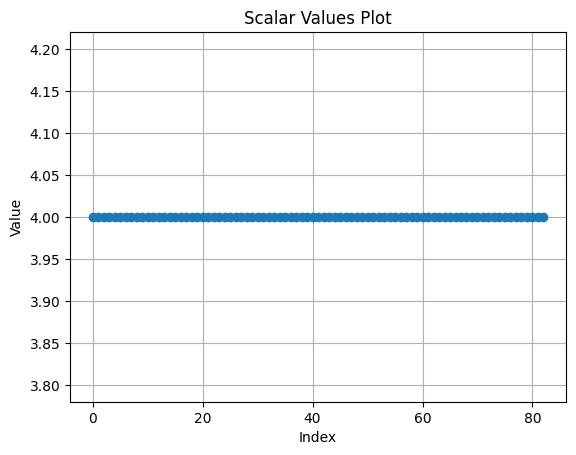

In [10]:
import matplotlib.pyplot as plt

plt.plot(pnl_list, marker='o')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scalar Values Plot')
plt.grid(True)
plt.show()

Phase 1: Preparing hyperparameter evaluation tasks...
Phase 1: Running 166 hyperparameter PNL calculations in parallel...


Phase 1: Hyperparameter PNL calculations completed.
Phase 2: Determining best hyperparameters and preparing final evaluation tasks...
Phase 2: Running 83 final window evaluations in parallel...
Phase 2: Final window evaluations completed.
All processing finished.


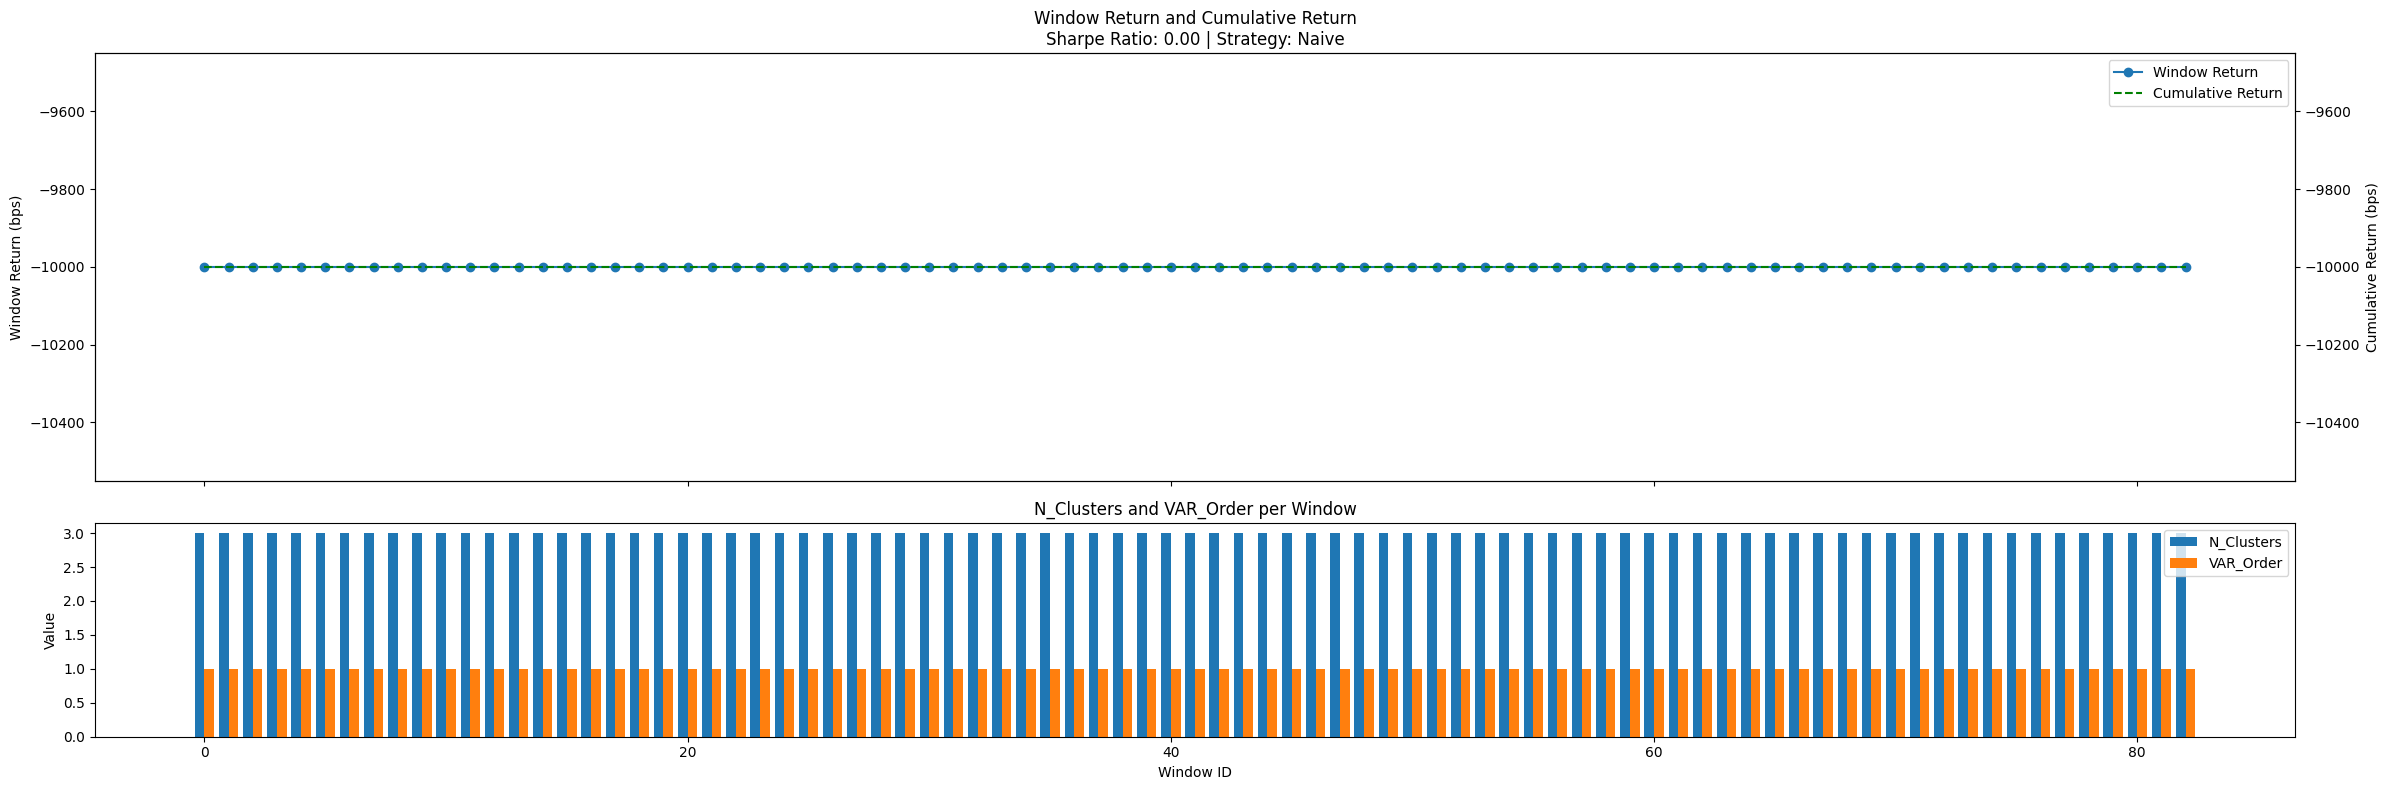

In [8]:
run_for_strategy_type("naive")

In [ ]:
run_for_strategy_type("weighted")

Phase 1: Preparing hyperparameter evaluation tasks...
Phase 1: Running 166 hyperparameter PNL calculations in parallel...


Phase 1: Preparing hyperparameter evaluation tasks...
Phase 1: Running 4760 hyperparameter PNL calculations in parallel...
Phase 1: Hyperparameter PNL calculations completed.
Phase 2: Determining best hyperparameters and preparing final evaluation tasks...
Phase 2: Running 238 final window evaluations in parallel...
Phase 2: Final window evaluations completed.
All processing finished.


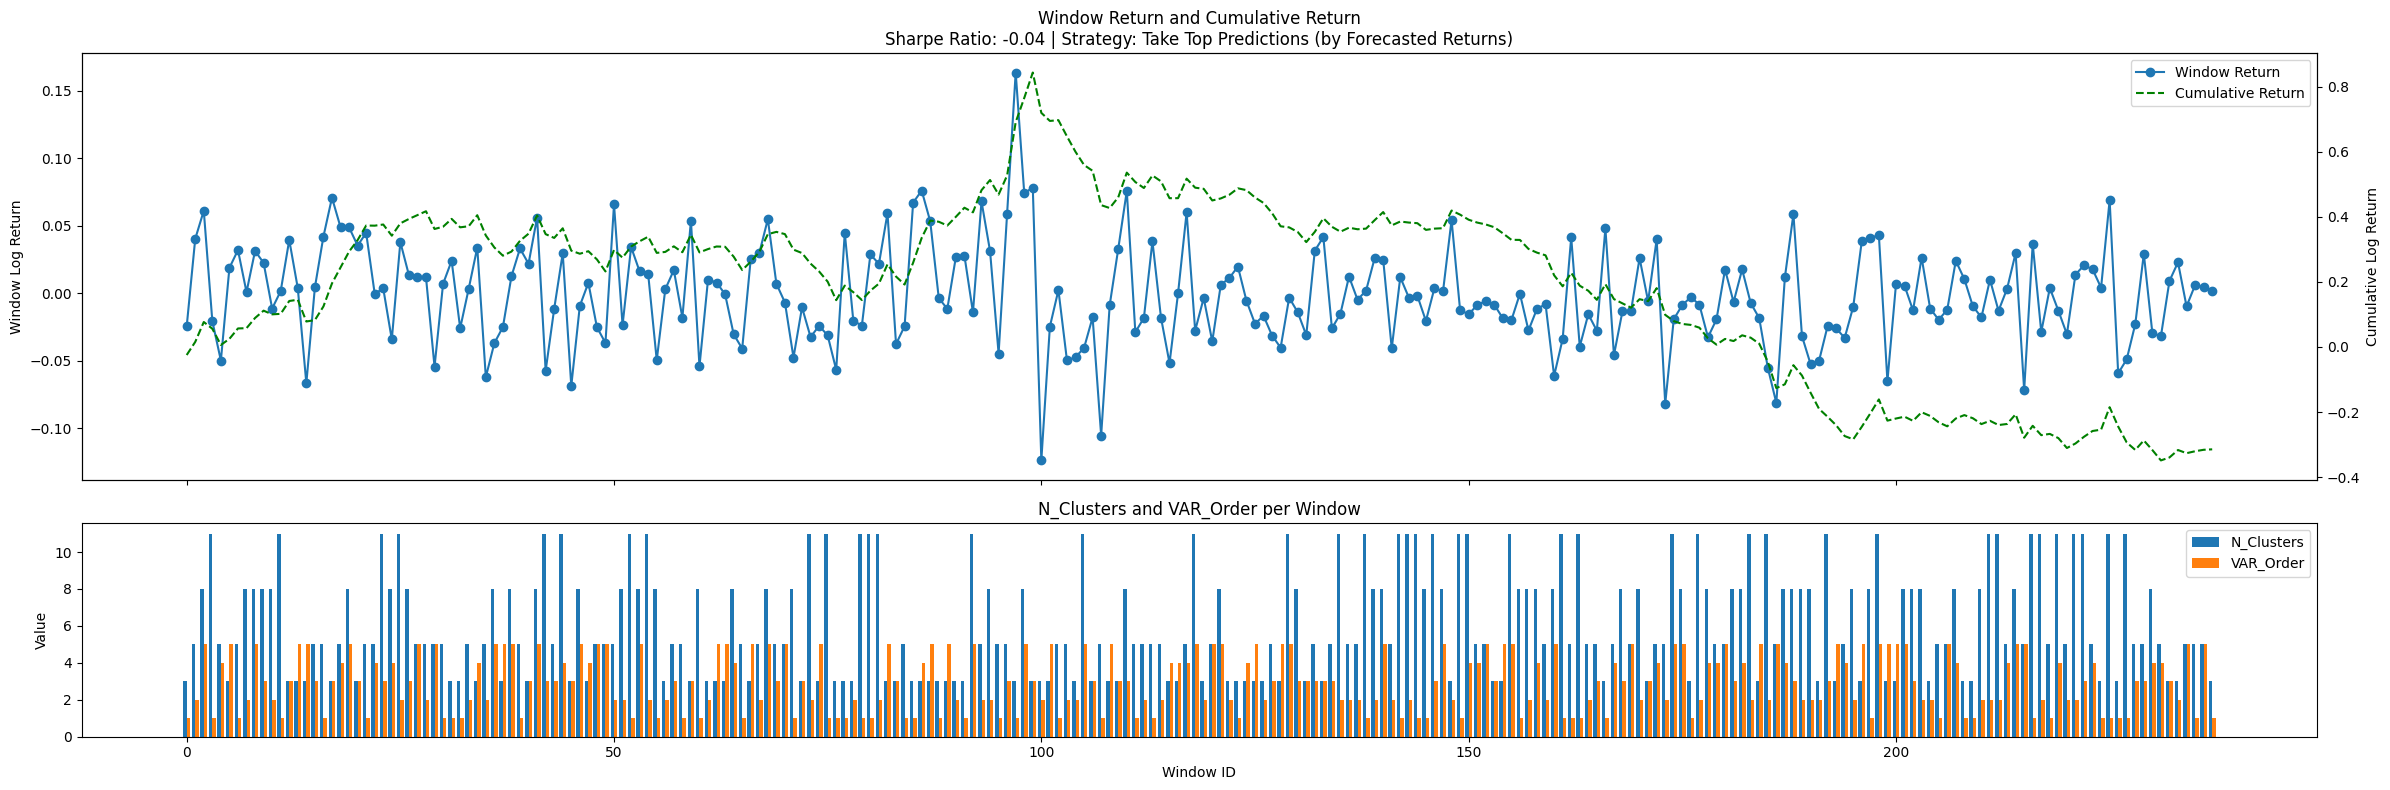

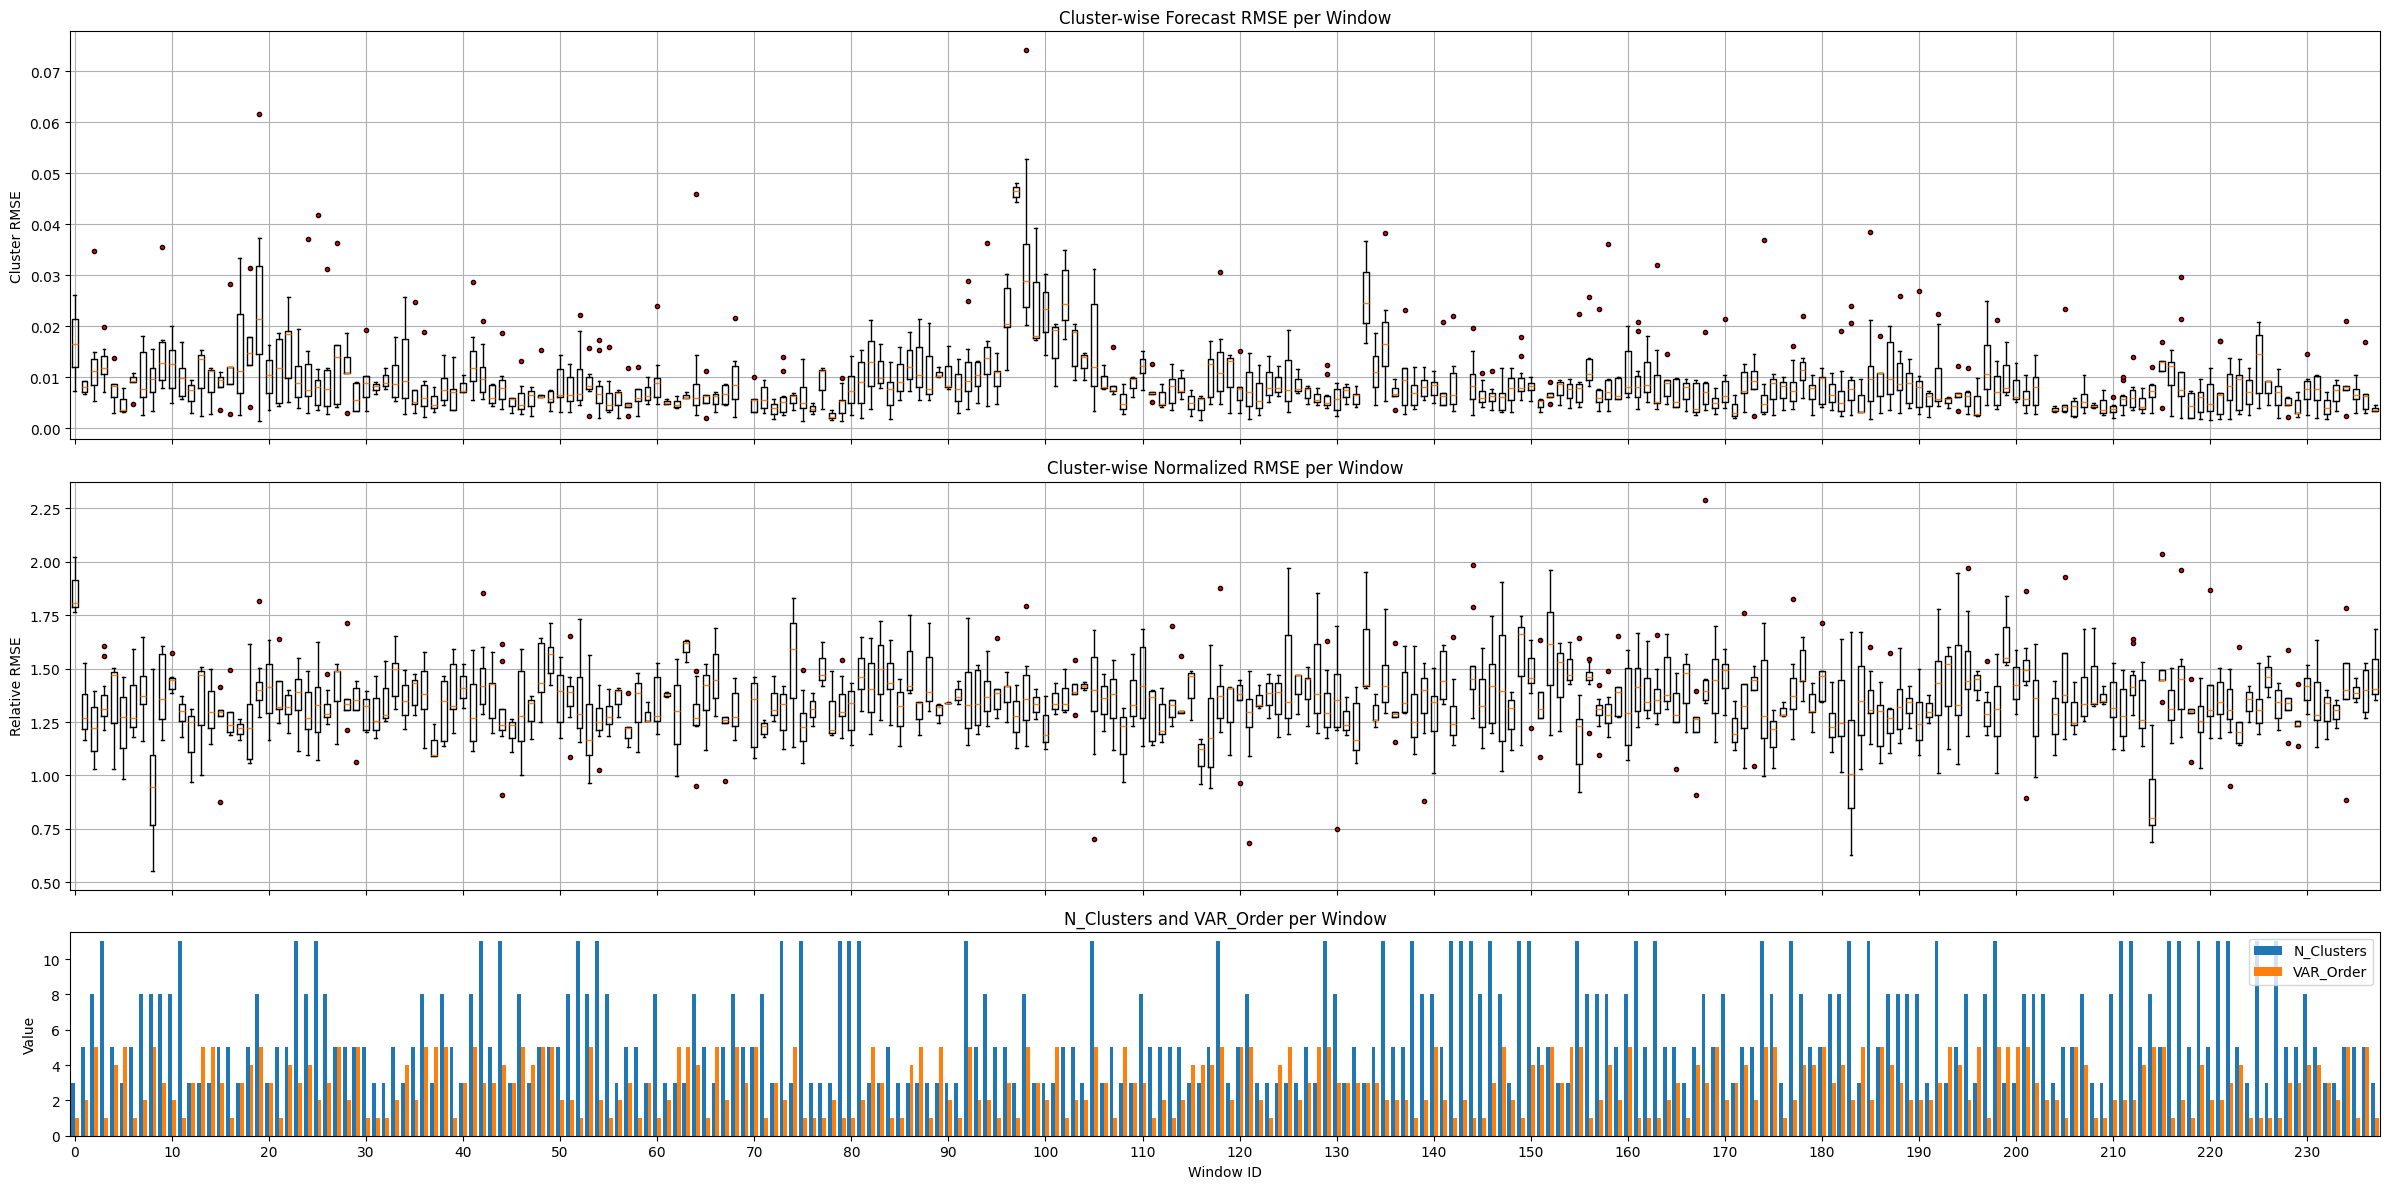

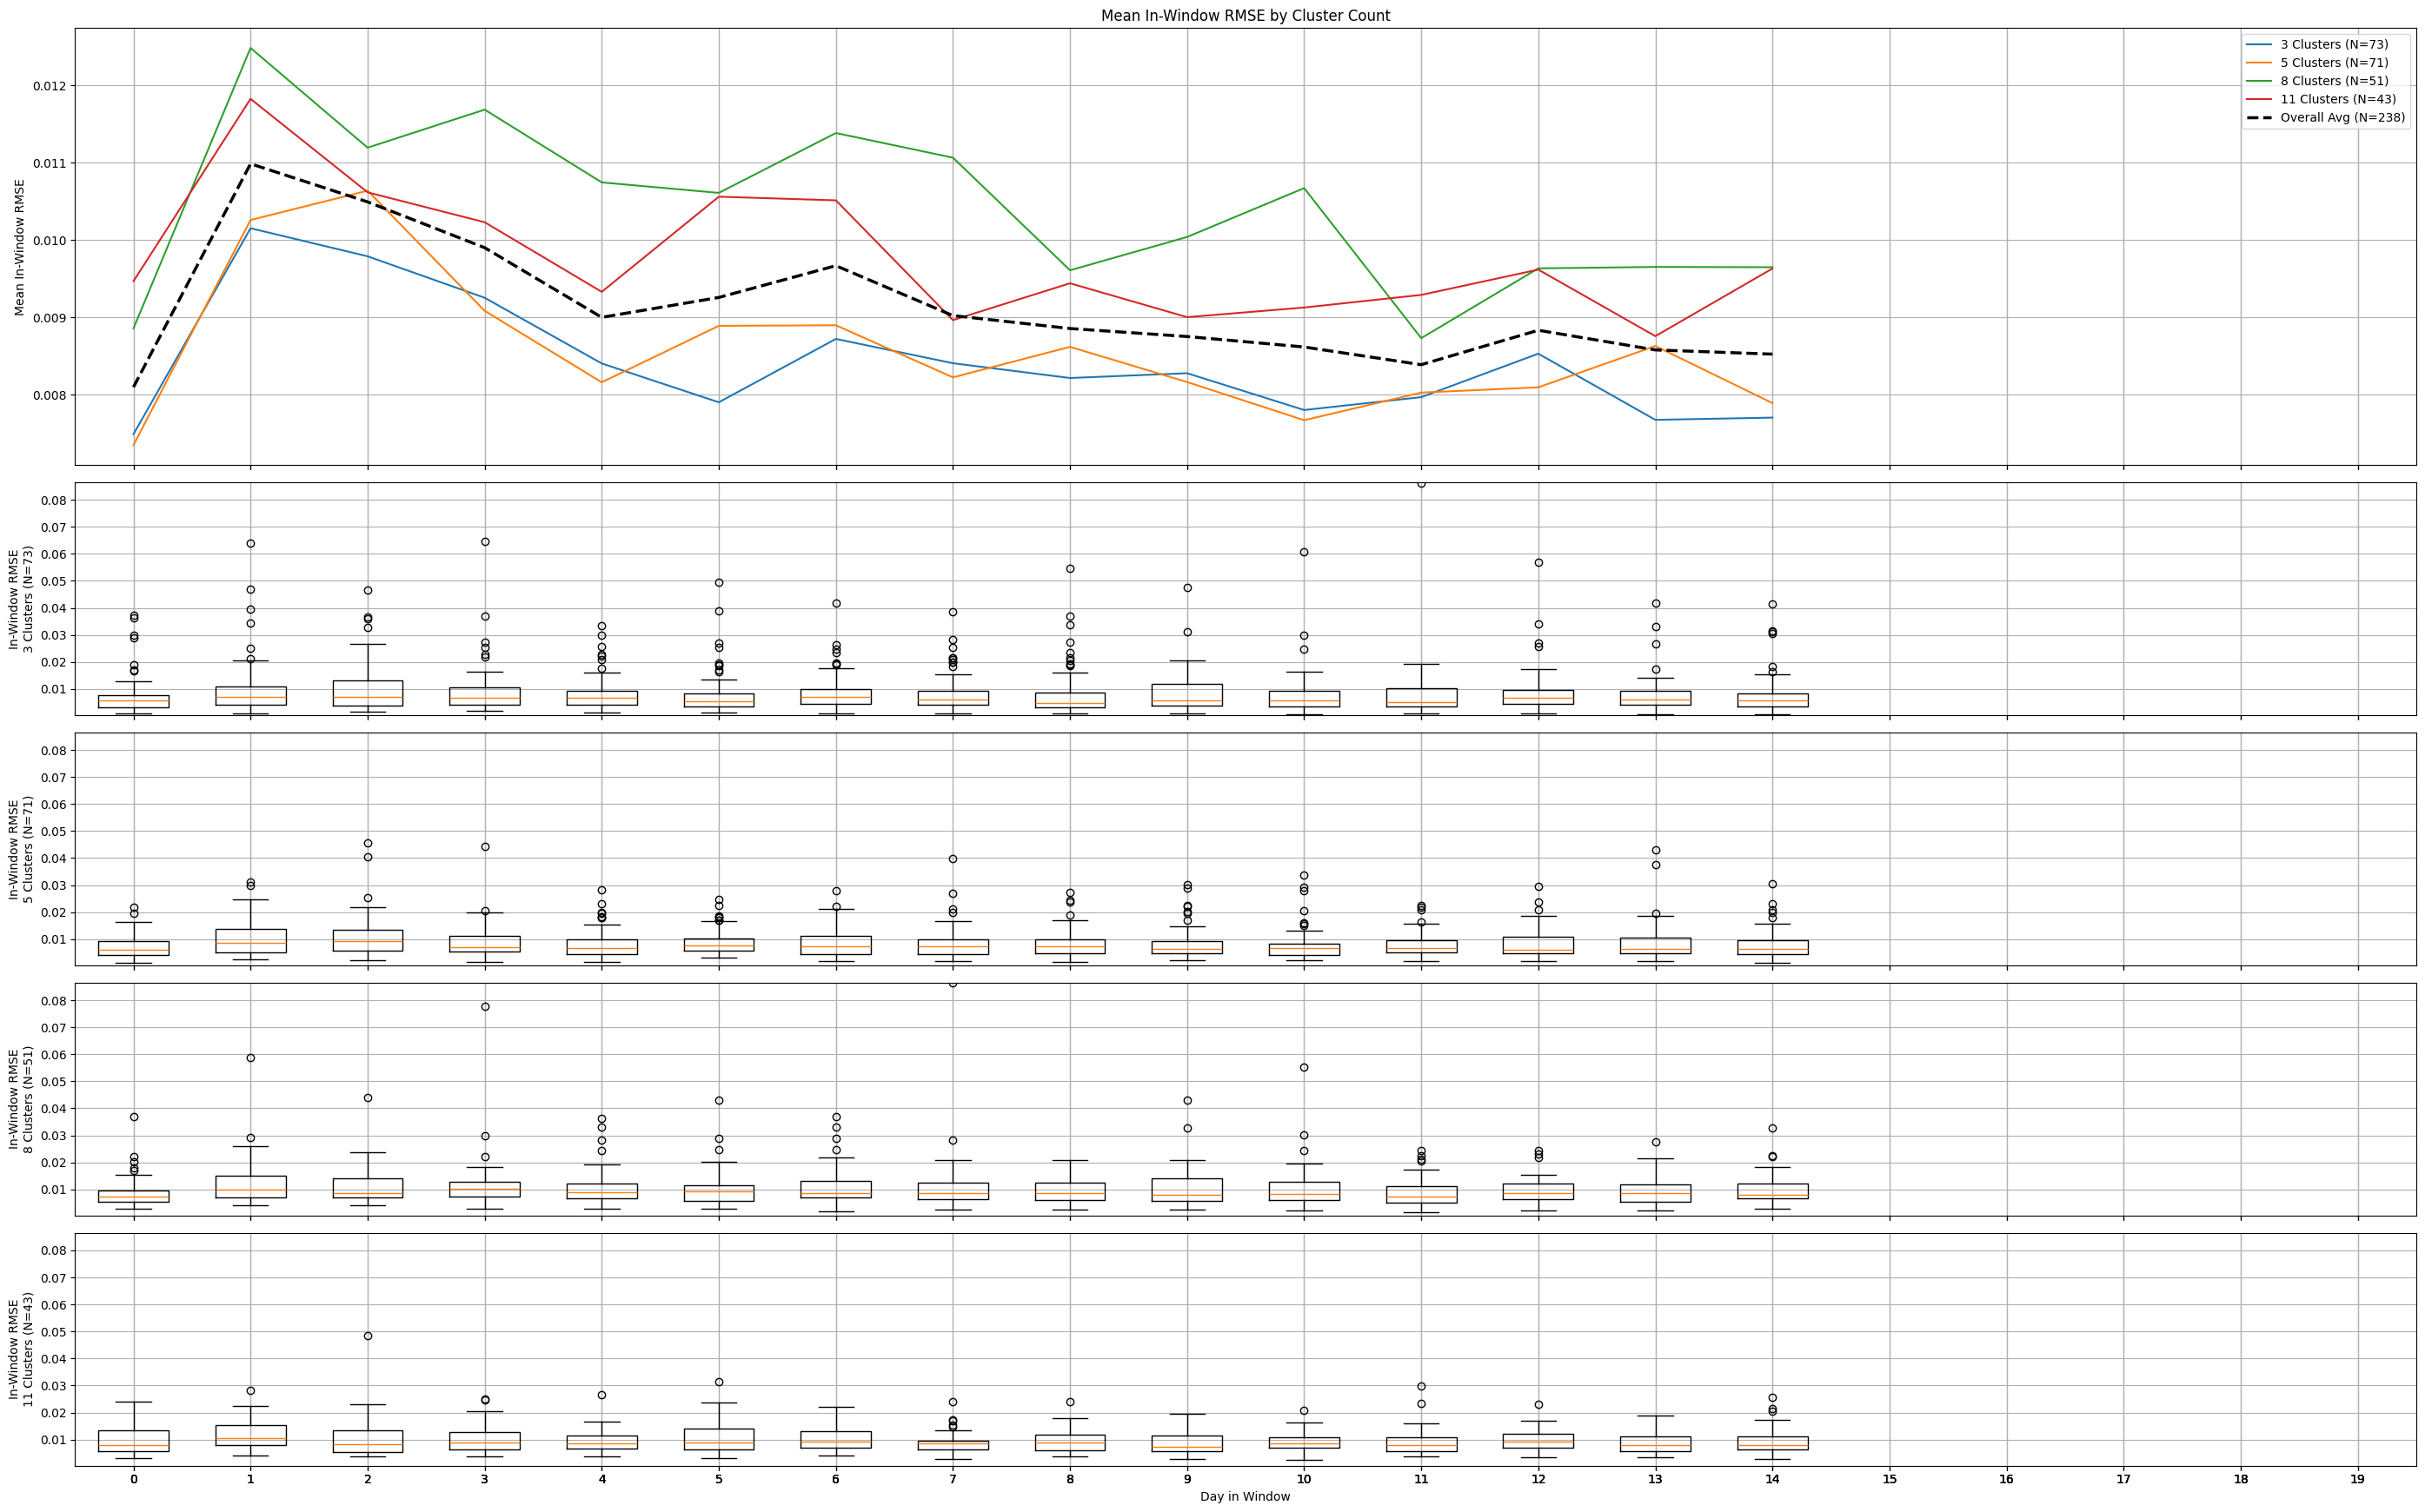

In [ ]:
run_for_strategy_type("top")

## Run on Test Dataset

In [ ]:
# Append 1 lookback length from the end of the train dataset to the test dataset
df_test_dataset = pd.concat([df_train_dataset.iloc[-1*initial_lookback_len:], df_test_dataset], axis=0)

print(f"\n===== Running Parallelized Grid Search Evaluation (Simplified Edges) =====")
results_dict = run_sliding_window_var_evaluation_vectorized(
    asset_returns_df=df_test_dataset,
    initial_lookback_len=initial_lookback_len,
    eval_len=evaluation_len,
    repetitions=repetitions,
    n_clusters_config=num_clusters_config,
    cluster_method=cluster_method_config,
    var_order_config=var_orders_config,
    sigma_intra_cluster=sigma_config,
    # num_windows_config=num_windows_config,
    # num_windows_config=20,
    num_windows_config=60,
    store_sample_forecasts=True,
    run_naive_var_comparison=True,

    max_threads=8
)

In [ ]:
avg_pnl_pivot = df_all_pnl_by_lag_method.pivot_table(
    index=pivot_index_cols,
    columns='Method',
    values='Avg_Window_PNL',
    aggfunc='mean'
)
print(avg_pnl_pivot)

# Plotting (assumes data is present for plots)
plt.figure(figsize=(14, 8))
sns.boxplot(x='VAR_Order', y='Avg_Window_PNL', hue='Method', data=df_all_pnl_by_lag_method)
plt.title(f'Distribution of Average Window PNL by Selected VAR Lag Order and Method')
plt.xlabel('Selected VAR Lag Order for Window')
plt.ylabel(f'Average Window PNL')
plt.legend(title='Forecast Method')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()